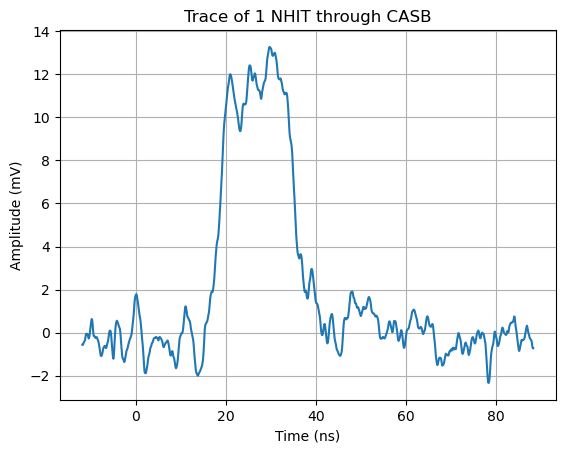

In [30]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats

def plot_waveform(df,n):
    try:
        # Plot the data
        plt.plot(df["Time"]*1e9, 1e3*(df["Amplitude"]-0.1225), linestyle='-', label=file_path)
        plt.xlabel("Time (ns)")
        plt.ylabel("Amplitude (mV)")
        plt.title("Trace of 1 NHIT through CASB")
        plt.grid(True)
        #plt.xlim(20,40)
        
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")

# Loop through files from C1--Trace--0000.txt to C1--Trace--0030.txt
for i in range(2,3):
    file_path = f'C1--Trace--{i:05d}.txt'  # Format number to 4 digits with leading zeros
    df_casb = pd.read_csv(file_path, skiprows=5, names=["Time", "Amplitude"])
    plot_waveform(df_casb,i)

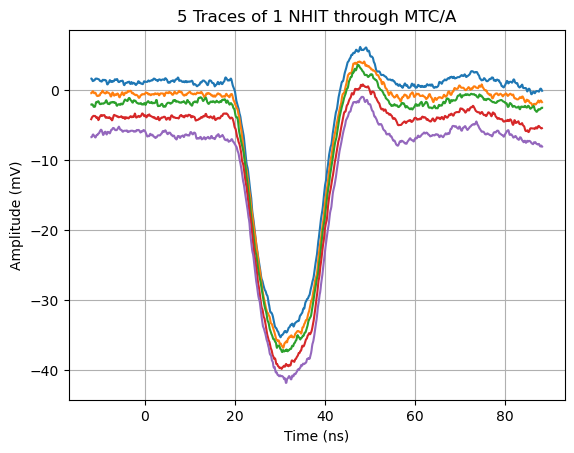

In [17]:
def plot_waveform(df,n):
    try:
        # Plot the data
        plt.plot(df["Time"]*1e9, 1e3*(df["Amplitude"]+0.84), linestyle='-', label=file_path)
        plt.xlabel("Time (ns)")
        plt.ylabel("Amplitude (mV)")
        plt.title(f"{n} Traces of 1 NHIT through MTC/A")
        plt.grid(True)
        #plt.xlim(20,40)
        
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")

# Loop through files from C1--Trace--0000.txt to C1--Trace--0030.txt
n=5
for i in range(n):
    file_path = f'../mtca-nhit/C4--Trace--{i:05d}.txt'  # Format number to 4 digits with leading zeros
    df_mtca = pd.read_csv(file_path, skiprows=5, names=["Time", "Amplitude"])
    plot_waveform(df_mtca,n)


In [11]:
def getPeakIndex(data):
    peak=0
    peak_i=0
    for i in range(len(data)):
        if data[i]>peak:
            peak=data[i]
            peak_i=i
    return peak_i

def getPedestal(data):
    avg=0
    d=int(len(data)/10)
    for i in range(d):
        avg+=data[i]
    return avg/d

def getCrossingTime(time,data,thresh):
    over=0 # first index where data crosses threshold
    under=0 # index before crossing threshold 
    for i in range(len(data)):
        if data[i]>thresh:
            over=i
            under=i-1
            break
    #print(under,over)
    m=(data[over]-data[under])/(time[over]-time[under])
    cross_time=time[under]+((thresh-data[under])/m)
    #print(time[under]*1e9,round(cross_time*1e9,2),time[over]*1e9)
    return cross_time

def getRiseTime(time,data,threshLowPC,threshHighPC):
    peak_i=getPeakIndex(data)
    ped=getPedestal(data)
    amp=data[peak_i]-ped
    #print(amp)
    threshLow=ped+amp*threshLowPC/100
    threshHigh=ped+amp*threshHighPC/100
    tLow=getCrossingTime(time,data,threshLow)*1e9
    tHigh=getCrossingTime(time,data,threshHigh)*1e9
    rt=tHigh-tLow
    return round(rt,3)

start,end=20,80

casb=[]
for i in range(30):
    file_path = f'C1--Trace--{i:05d}.txt'  # Format number to 4 digits with leading zeros
    df = pd.read_csv(file_path, skiprows=5, names=["Time", "Amplitude"])
    rt=getRiseTime(df['Time'],df['Amplitude'],start,end)
    casb.append(rt)
    
mtca=[]    
for i in range(35):
    file_path = f'../mtca-nhit/C4--Trace--{i:05d}.txt'  # Format number to 4 digits with leading zeros
    df = pd.read_csv(file_path, skiprows=5, names=["Time", "Amplitude"])
    rt=getRiseTime(df['Time'],df['Amplitude']*-1,start,end)
    mtca.append(rt)
#print("-----------------------------------------------------")
#print(f"RISETIMES {rt90}")
#print("-----------------------------------------------------")
#print(f"AVG {sum(rt90)/len(rt90):>{10}.3f}")
#print(f"STD {stats.stdev(rt90):>{10}.3f}")
#print(f"MAX {max(rt90):>{10}.3f}")
#print(f"MIN {min(rt90):>{10}.3f}")

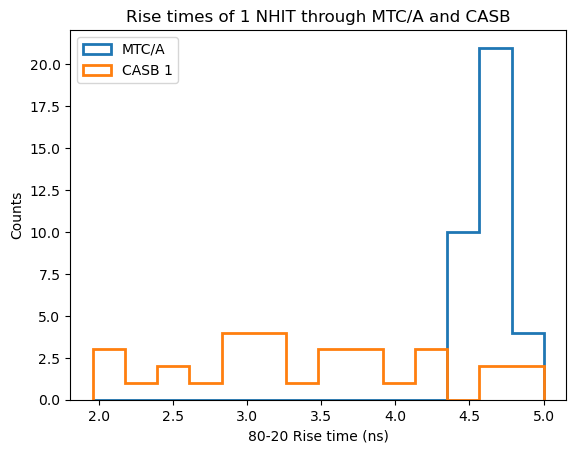

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Determine shared bins
all_data = mtca + casb
bins = np.linspace(min(all_data), max(all_data), 15)

# Plot histograms with shared bins
plt.hist(mtca, bins=bins, density=False, histtype='step', label='MTC/A', linewidth=2)
plt.hist(casb, bins=bins, density=False, histtype='step', label='CASB 1', linewidth=2)

# Add labels, legend, and title
plt.xlabel(f'{end}-{start} Rise time (ns)')
plt.ylabel('Counts')
plt.title('Rise times of 1 NHIT through MTC/A and CASB')
#plt.yticks(np.arange(0,40,5))
plt.legend()

# Display the plot
plt.show()


In [9]:
start,end=20,80

# get length
file_path = f'C1--Trace--00000.txt'  # Format number to 4 digits with leading zeros
temp = pd.read_csv(file_path, skiprows=5, names=["Time", "Amplitude"])

casb_avg_time=np.zeros(len(temp['Time']))
casb_avg_amp=np.zeros(len(temp['Time']))
for i in range(30):
    file_path = f'C1--Trace--{i:05d}.txt'  # Format number to 4 digits with leading zeros
    df = pd.read_csv(file_path, skiprows=5, names=["Time", "Amplitude"])
    for i in range(len(df['Time'])):
        casb_avg_time[i]=casb_avg_time[i]+df["Time"][i]
        casb_avg_amp[i]=casb_avg_amp[i]+df["Amplitude"][i]
casb_avg_time=casb_avg_time/30
casb_avg_amp=casb_avg_amp/30
casb_avg_rt=getRiseTime(casb_avg_time,casb_avg_amp,start,end)
print(f"Average CASB {end}-{start} rise time: {casb_avg_rt}")

mtca_avg_time=np.zeros(len(temp['Time']))
mtca_avg_amp=np.zeros(len(temp['Amplitude']))
for i in range(35):
    file_path = f'../mtca-nhit/C4--Trace--{i:05d}.txt'  # Format number to 4 digits with leading zeros
    df = pd.read_csv(file_path, skiprows=5, names=["Time", "Amplitude"])
    for i in range(len(df['Time'])):
        mtca_avg_time[i]=mtca_avg_time[i]+df['Time'][i]
        mtca_avg_amp[i]=mtca_avg_amp[i]+df['Amplitude'][i]
mtca_avg_time=mtca_avg_time/35
mtca_acg_amp=mtca_avg_amp/35
mtca_avg_rt=getRiseTime(mtca_avg_time,mtca_avg_amp*-1,start,end)
print(f"Average MTC/A {end}-{start} rise time: {mtca_avg_rt}")

Average CASB 80-20 rise time: 3.039
Average MTC/A 80-20 rise time: 4.542


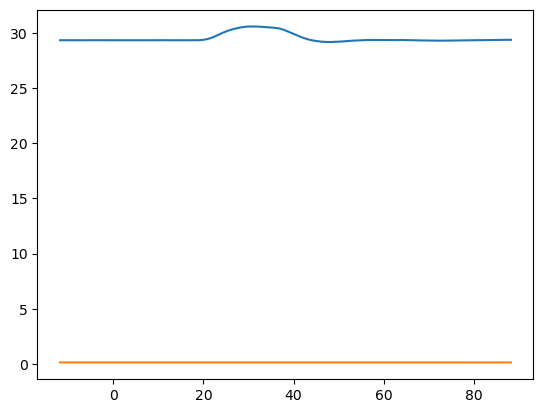

In [10]:
plt.plot(mtca_avg_time*1e9,-1*mtca_avg_amp)
plt.plot(casb_avg_time*1e9,casb_avg_amp)

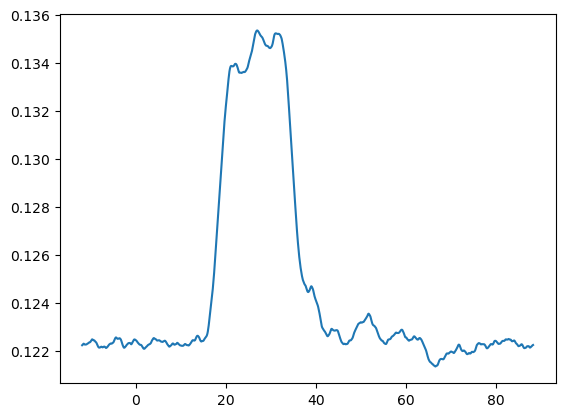

In [82]:
plt.plot(casb_avg_time*1e9,casb_avg_amp)

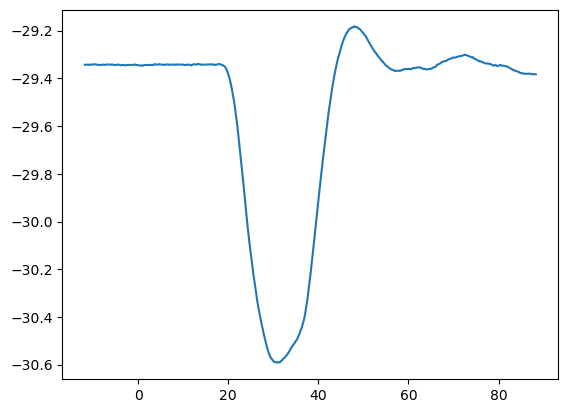

In [83]:
plt.plot(mtca_avg_time*1e9,mtca_avg_amp)